***Developing an Analytical Approximation to the Variation of Epigenetic Lineage Markers during Cancer Evolution***

This notebook is a companion to the thesis submitted for my MSci in Mathematics. Here, I will show how I simulated and generated most of my main results, using an adaptation of EVOFLUx (https://github.com/CalumGabbutt/evoflux). 

The basis of the model is fCpGs, regions in DNA that fluctuate stochastically in methylation over time. In a diploid population, an individual can be in one of three states: homozygous demethylated (0% methylated), heterozygous methylated (50% methylated), and homozygous methylated (100% methylated). We define transition rates $2\mu,2\gamma,\nu,\zeta$ between the states as follows:

$2\mu$: transition rate from homozygous demethylated to heterozygous methylated.

$2\gamma$: transition rate from homozygous methylated to heterozygous methylated.

$\nu$: transition rate from heterozygous methylated to homozygous methylated.

$\zeta$: transition rate from heterozygous methylated to homozygous demethylated.

We also assume that the population is growing exponentially with fixed rate $\theta$, ie the size of the population at time $t$ $N(t)=e^{\theta t}$. 

In the following code, we define $T$ as the end of the process, and $\tau$ the time at which the cancer process began; that is, if $T=50$ and $\tau=45$, then the cancer process has been going on for 5 years by the end of the simulation.

The first chunk of cells are a number of necessary function declarations.

In [1]:
from scipy import stats, linalg
import numpy as np
import pandas as pd
import os
from scipy.special import logsumexp, logit, softmax
from scipy.special import gamma as gammafunc
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns   
from scipy.stats import invweibull
from scipy.integrate import quad

In [2]:
def generate_next_timepoint(m, k, w, mu, gamma, nu, zeta, S, dt, rng=None):
    """
    Simulates the transitions between the homozygous demtheylated, heterozygous
    and homozygous methylated states in a time step dt in a pool of S cells.

    Arguments:
        m: number of homozygous methylated cells - array of the ints
        k: number of heterozygous methylated cells - array of the ints
        w: number of homozygous demethylated cells - array of the ints
        mu: rate to transition from homozygous demethylated to heterozygous
            - float >= 0
        gamma: rate to transition from homozygous methylated to heterozygous
            - float >= 0
        nu: rate to transition from heterozygous to homozygous methylated
            - float >= 0
        zeta: rate to transition from heterozygous to homozygous demethylated
            - float >= 0         
        S: total number of cells all(m + k + w == S) - int
        dt: time step - float > 0
        rng: np.random.default_rng() object, Optional
    Returns:
        Updated m, k, w after transitions have occurred
    """

    if rng is None:
        rng = np.random.default_rng()

    NSIM = len(m)

    # Use sequential rounds of binomial sampling to calculate how many cells
    # transition between each state
    m_to_k, k_out, w_to_k = rng.binomial(
                                    n = (m, k, w), 
                                    p = np.tile([2*gamma*dt, 
                                        (nu + zeta)*dt, 2*mu*dt], [NSIM, 1]).T)

    k_to_m = rng.binomial(n=k_out, p = np.repeat(nu / (nu + zeta), NSIM))

    m = m - m_to_k + k_to_m
    k = k - k_out + m_to_k + w_to_k
    w = S - m - k

    return (m, k, w)

In [3]:
def multinomial_rvs(counts, p, rng=None):
    """
    Simulate multinomial sampling of D dimensional probability distribution

    Arguments:
        counts: number of draws from distribution - int or array of the 
                ints (N)
        p: probability  - array of the floats (D, N)
        rng: np.random.default_rng() object, Optional
    Returns:
        Multinomial sample
    """

    if rng is None:
        rng = np.random.default_rng()

    if not isinstance(counts, (np.ndarray)):
        counts = np.full(p[0, ...].shape, counts)

    out = np.zeros(np.shape(p), dtype=int)
    ps = np.cumsum(p[::-1, ...], axis=0)[::-1, ...]
    # Conditional probabilities
    with np.errstate(divide='ignore', invalid='ignore'):
        condp = p / ps
    condp[np.isnan(condp)] = 0.0

    for i in range(p.shape[0]-1):
        binsample = rng.binomial(counts, condp[i, ...])
        out[i, ...] = binsample
        counts -= binsample

    out[-1, ...] = counts

    return out

In [4]:
def initialise_cancer(tau, mu, gamma, nu, zeta, NSIM, rng=None, init = None):
    """
    Initialise a cancer, assigning fCpG states assuming fCpGs are homozygous 
    at t=0

    Arguments:
        tau: age when population began expanding exponentially - float
        mu: rate to transition from homozygous demethylated to heterozygous
            - float >= 0
        gamma: rate to transition from homozygous methylated to heterozygous
            - float >= 0
        nu: rate to transition from heterozygous to homozygous methylated
            - float >= 0
        zeta: rate to transition from heterozygous to homozygous demethylated
            - float >= 0         
        NSIM: number of fCpG loci to simulate - int
        rng: np.random.default_rng() object, Optional
        init: allowed values 0, 1, 2 or None. If None, initialise assuming
                time cancer began at time time tau, otherwise initailise in 
                0: w, 1: k, or 2: m. 
    Returns:
        m_cancer, k_cancer, w_cancer: number of homo meth, hetet meth and 
                homo unmeth cells in the population - np.array[int]
    """

    if rng is None:
        rng = np.random.default_rng()

    if init is None:
        # assume fCpG's are homozygous methylated at t=0
        mkw = np.zeros((3, NSIM), dtype = int)
        idx = np.arange(NSIM)
        np.random.shuffle(idx)
        mkw[0, idx[:NSIM//2]] = 1
        mkw[2, idx[NSIM//2:]] = 1

        # generate distribution of fCpG loci when population begins growing 
        # at t=tau
        RateMatrix = np.array([[-2*gamma, nu, 0], 
                                [2*gamma, -(nu+zeta), 2*mu], 
                                [0, zeta, -2*mu]])

        ProbStates = linalg.expm(RateMatrix * tau) @ mkw

        m_cancer, k_cancer, w_cancer = multinomial_rvs(1, ProbStates, rng)
    
    elif init in [0, 1, 2]:
        wkm = np.zeros((3, NSIM), dtype = int)
        wkm[init, :] = 1

        w_cancer, k_cancer, m_cancer = wkm

    else:
        raise ValueError('init must be None or 0, 1 or 2')

    return m_cancer, k_cancer, w_cancer

In [5]:
def grow_cancer(m_cancer, k_cancer, w_cancer, S_cancer_i, S_cancer_iPlus1, rng):
    """
    Grow a cancer, assigning fCpG states according to a multinomial ditribution

    Arguments:
        m_cancer, k_cancer, w_cancer: number of homo meth, hetet meth and 
                homo unmeth cells in the population - np.array[int]
        S_cancer_i: number of cells at time t - int = m_cancer + k_cancer + w_cancer
        S_cancer_iPlus1: number of cells at time t+dt - int >= S_cancer_i
        rng: np.random.default_rng() object, Optional
    Returns:
        Updated m_cancer, k_cancer, w_cancer
    """

    if rng is None:
        rng = np.random.default_rng()

    if S_cancer_iPlus1 - S_cancer_i > 0:
        prob_matrix = np.stack((m_cancer, k_cancer, w_cancer)) / S_cancer_i
        growth = multinomial_rvs(S_cancer_iPlus1 - S_cancer_i, prob_matrix, rng)

        m_cancer += growth[0, :]
        k_cancer += growth[1, :]
        w_cancer += growth[2, :]

    return m_cancer, k_cancer, w_cancer

In [6]:
def stochastic_growth(theta, tau, mu, gamma, nu, zeta, T, NSIM, init = None):
    """
    Simulate the methylation distribution of fCpG loci for an exponentially 
    growing well-mixed population evolving neutrally

    Arguments:
        theta: exponential growth rate of population - float
        tau: age when population began expanding exponentially - float < T
        mu: rate to transition from homozygous demethylated to heterozygous
            - float >= 0
        gamma: rate to transition from homozygous methylated to heterozygous
            - float >= 0
        nu: rate to transition from heterozygous to homozygous methylated
            - float >= 0
        zeta: rate to transition from heterozygous to homozygous demethylated
            - float >= 0         
        T: patient's age - float
        NSIM: number of fCpG loci to simulate - int
    Returns:
        betaCancer: fCpG methylation fraction distribution - np.array[float]
    """

    # calculate the time step so all transition probabilities are <= 10%
    dt_max = 0.01 / np.max((
        2*gamma, 
        2*mu,
        2*nu,
        2*zeta,
        theta)
    )
    
    # calculate deterministic exponential growth population size
    n = int((T-tau) / dt_max) + 2  # Number of time steps.
    t = np.linspace(tau, T, n) 
    dt = t[1] - t[0]
    S_cancer = np.exp(theta * (t-tau)).astype(int)

    if np.any(S_cancer < 0):
        raise(OverflowError('overflow encountered for S_cancer'))

    rng = np.random.default_rng()

    # generate distribution of fCpG loci depending on init param
    m_cancer, k_cancer, w_cancer = initialise_cancer(tau, mu, gamma, nu, zeta, 
                                                     NSIM, rng, init)

    # simulate changes to methylation distribution by splitting the process 
    # into 2 phases, an exponential growth phase and a methylation transition 
    # phase
    for i in range(len(t)-1):
        m_cancer, k_cancer, w_cancer = grow_cancer(m_cancer, k_cancer,
                                                    w_cancer, S_cancer[i], 
                                                    S_cancer[i+1], rng)

        m_cancer, k_cancer, w_cancer = generate_next_timepoint(m_cancer, 
                                                    k_cancer, w_cancer, 
                                                    mu, gamma, nu, zeta,
                                                    S_cancer[i+1], dt, rng)

    with np.errstate(divide='raise', over='raise'):
        betaCancer = (k_cancer + 2*m_cancer) / (2*S_cancer[-1])

    return betaCancer

Here, we calculate the mixing weights for the mixture model. We use matrix exponentiation on the transition rate matrix $B$ to solve an ordinary differential equation with an initial condition. This initial condition comes from the assumption that all fCpGs are homozygous upon initialisation.

In [7]:
def calculate_mixing_weight_lpmf(mu, gamma, nu, zeta, tau):
    # generate distribution of fCpG loci when population begins growing 
    # at t=tau
    RateMatrix = np.array([[-2*gamma, nu, 0], 
                            [2*gamma, -(nu+zeta), 2*mu], 
                            [0, zeta, -2*mu]])
    
    # assume population is either homozygous methylated or demethylated at t=0
    mkw = np.array([0.5, 0, 0.5]).T

    # use matrix exponentiation to solve to for the mixing weights
    ProbStates = linalg.expm(RateMatrix * tau) @ mkw

    return np.log(ProbStates)

The Fréchet parameters are calculated as in Section 3.2.1 of the paper.

In [8]:
def calculate_frechet_parameters(mut_rate, theta, deltaT):

    a = np.exp(1) / 2
    m_norm = 0.5 * mut_rate / theta * (theta * deltaT + np.log(mut_rate / theta ) - (1 + a))
    s_norm = 0.5 * np.exp(1) * mut_rate / theta

    return a, m_norm, s_norm

The log PDF of each peak is calculated as in the paper. Since the heterozygous peak is a difference of two random variables, we must integrate and perform a convolution to calculate its PDF.

In [9]:
def demeth_homo_init_lpdf(y, theta, mu, tau, T):

    a, m_norm, s_norm = calculate_frechet_parameters(2 * mu, theta, T - tau)

    return invweibull.logpdf(y, a, loc = m_norm, scale = s_norm)

In [10]:
def meth_homo_init_lpdf(y, theta, gamma, tau, T):

    a, m_norm, s_norm = calculate_frechet_parameters(2 * gamma, theta, T - tau)

    return invweibull.logpdf(1-y, a, loc = m_norm, scale = s_norm)

In [11]:
def hetero_integrand(x, z, theta, nu, zeta, tau, T):

    a, m1_norm, s1_norm = calculate_frechet_parameters(nu, theta, T - tau)
    a, m2_norm, s2_norm = calculate_frechet_parameters(zeta, theta, T - tau)

    return np.exp(invweibull.logpdf(x, a, loc = m2_norm, scale = s2_norm) 
                  + invweibull.logpdf(z-0.5+x, a, loc = m1_norm, scale = s1_norm))

In [12]:
def meth_hetero_init_lpdf(y, theta, nu, zeta, tau, T):
    
    if isinstance(y, (list, tuple, np.ndarray)):
        integral = np.array([quad(hetero_integrand, 0, 1, 
                                args=(y_i, theta, nu, zeta, tau, T))[0]
                            for y_i in y])
    else:
        integral = quad(hetero_integrand, 0, 1, 
                            args=(y, theta, nu, zeta, tau, T))[0]

    return np.log(integral)

The overall log PDF is calculated using logsumexp to avoid both overflow and underflow.

In [13]:
def combined_lpdf(y, theta, tau, mu, gamma, nu, zeta, T):

    mixing_lpdf = calculate_mixing_weight_lpmf(mu, gamma, nu, zeta, tau)

    left_peak = demeth_homo_init_lpdf(y, theta, mu, tau, T)
    central_peak = meth_hetero_init_lpdf(y, theta, nu, zeta, tau, T)
    right_peak = meth_homo_init_lpdf(y, theta, gamma, tau, T)

    # Combine using logsumexp: log(w1*p1 + w2*p2 + w3*p3) = 
    # logsumexp([log(w1)+log(p1), log(w2)+log(p2), log(w3)+log(p3)])
    log_weighted_components = np.array([
        mixing_lpdf[0] + right_peak,    # log(w1) + log(p1) for demethylated homozygous
        mixing_lpdf[1] + central_peak, # log(w2) + log(p2) for heterozygous  
        mixing_lpdf[2] + left_peak    # log(w3) + log(p3) for methylated homozygous
    ])
    
    # Use logsumexp to compute the final combined log probability density
    combined_lpdf = logsumexp(log_weighted_components, axis=0)

    return combined_lpdf

In [14]:
def fit_landau_rvs(beta):
    loc, scale = stats.landau.fit(beta)
    return stats.landau.rvs(loc, scale, size=10000)

In [15]:
from scipy.linalg import expm


def analytic_calculation(t, theta, mu, gamma, nu, zeta):
    B = np.array([[theta - 2 * gamma, nu, 0], [2 * gamma, theta - (nu + zeta), 2 * mu], [0, zeta, theta - 2 * mu]])

    exponential = expm(t * B)

    return (exponential[0, :] + 0.5 * exponential[1, :]) / np.exp(t * theta)

We calculate the overall scaling factor of the histogram, in order to allow the spike to contribute.

In [16]:
def calculate_scaling_factor(beta):
    hist = np.histogram(beta, bins=np.linspace(0, 1, 201), density=True)
    nondense_hist = np.histogram(beta, bins=np.linspace(0, 1, 201), density=False)
    prop = np.max(nondense_hist[0])/np.sum(nondense_hist[0])
    scale = np.max(hist[0])/prop

    return scale

In [17]:
def calculate_spike_height(beta, mu, theta):
    scale = calculate_scaling_factor(beta)

    return 2 * scale * mu * np.log(2)/theta

Here, we initialise parameters for the ***two-state case***

In [18]:
T = 50
tau = 45
theta = 2.4
mu = 0.04
gamma = 1e-12
nu = 1e-12
zeta = 1e-12

init = 0

The graph below shows the analytic approximation to the height of the spike at 0.5 compared with the stochastic calculation.

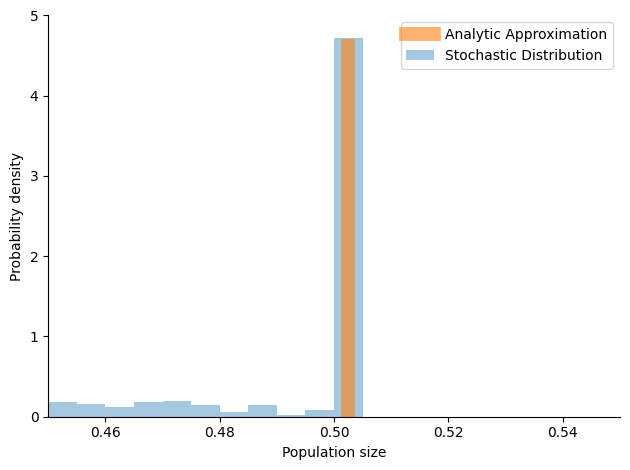

In [ ]:
betaCancer = stochastic_growth(theta, tau, mu, gamma, nu, zeta, T, 10000, init)

x = np.linspace(0, 1, 1001)

fig, ax = plt.subplots()


spike = calculate_spike_height(betaCancer, mu, theta)

plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.plot([0.5025, 0.5025], [0, spike], alpha=0.6, linewidth=10)
# plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.xlim(0.45, 0.55)
plt.ylim(0, 5)
plt.tight_layout()
plt.legend(labels=["Analytic Approximation", "Stochastic Distribution"])
sns.despine()
plt.show()

Below, we calculate the mean and variance of the distribution for a range of $\mu$ values, while keeping $\tau$ and $\theta$ fixed.

In [ ]:
from tqdm import tqdm

mu_vals = np.logspace(-5, -0.2, num=50)
mu_means = []
mu_vars = []

for mu_val in tqdm(mu_vals):
    betaPeak = stochastic_growth(theta, tau, mu_val, gamma, nu, zeta, T, 10000, init)
    mu_means.append(np.mean(betaPeak[np.argwhere(betaPeak != 0.5)]))    # Exclude the spike from the calculation of the mean
    mu_vars.append(np.var(betaPeak[np.argwhere(betaPeak != 0.5)]))


100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


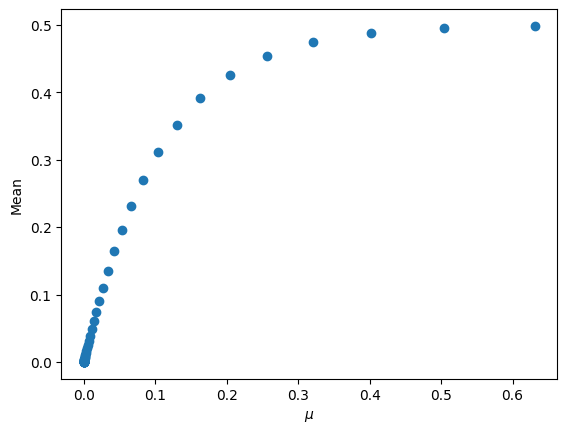

In [21]:
plt.scatter(mu_vals, mu_means)
plt.xlabel(r'$\mu$')
plt.ylabel("Mean")
plt.show()

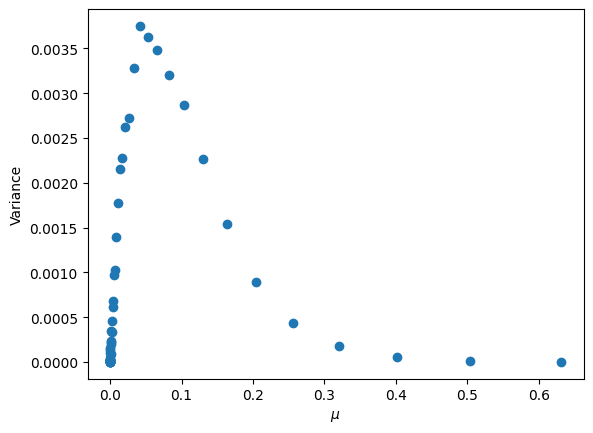

In [22]:
plt.scatter(mu_vals, mu_vars)
plt.xlabel(r'$\mu$')
plt.ylabel("Variance")
plt.show()

Here, we do the reverse; fixing $\mu$ and $\theta$ and varying $\tau$.

In [23]:
tau_vals = np.linspace(0.83, 1.0, num=50)
tau_means = []
tau_vars = []

for tau_val in tqdm(tau_vals):
    betaPeak = stochastic_growth(theta, tau_val * T, mu, gamma, nu, zeta, T, 10000, init)
    tau_means.append(np.mean(betaPeak[np.argwhere(betaPeak != 0.5)]))    # Exclude the spike from the calculation of the mean
    tau_vars.append(np.var(betaPeak[np.argwhere(betaPeak != 0.5)]))

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


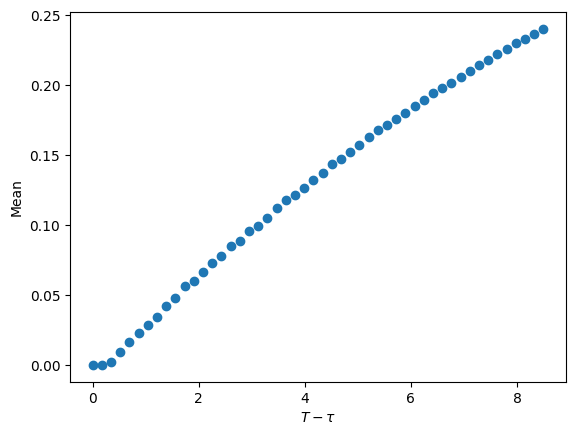

In [24]:
plt.scatter(T-tau_vals*T, tau_means)
plt.xlabel(r'$T-\tau$')
plt.ylabel("Mean")
plt.show()

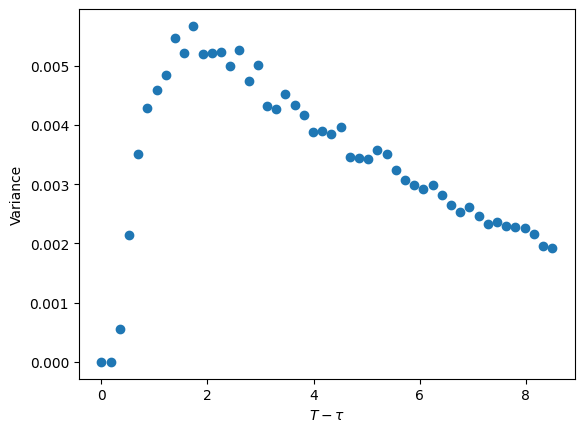

In [25]:
plt.scatter(T-tau_vals*T, tau_vars)
plt.xlabel(r'$T-\tau$')
plt.ylabel("Variance")
plt.show()

Now, we keep $\theta$ fixed and iterate over a grid of values for $\mu$ and $\tau$.

In [29]:
mu_vals_short = np.logspace(-5, -0.2, num=25)
tau_vals_short = np.linspace(0.83, 1.0, num=25)

mean_val_grid = np.zeros((len(mu_vals_short), len(tau_vals_short)))
var_val_grid = np.zeros((len(mu_vals_short), len(tau_vals_short)))

# Run the below to generate simulations - I have them pickled

# for i in tqdm(range(len(mu_vals_short))):
#     for j in range(len(tau_vals_short)):
#         betaPeak = stochastic_growth(theta, tau_vals_short[j] * T, mu_vals_short[i], gamma, nu, zeta, T, 10000, init)
#         mean_val_grid[i, j] = (np.mean(betaPeak[np.argwhere(betaPeak != 0.5)]))    # Exclude the spike from the calculation of the mean
#         var_val_grid[i, j] = (np.var(betaPeak[np.argwhere(betaPeak != 0.5)]))

In [32]:
import pickle

f = open('pickles/mean_val_grid.pkl', 'rb')
mean_val_grid = pickle.load(f)
f.close()

f = open('pickles/var_val_grid.pkl', 'rb')
var_val_grid = pickle.load(f)
f.close()

I found that the distribution of the mean looked like a logistic function, saturating at 0.5, so I used that functional form and used scipy.optimize.curve_fit to optimise the parameters.

In [27]:
def logistic(x, a, b, c, d):
    mu, tau_rel = x
    tau = T*tau_rel
    return (a*(mu*(T-tau))**b)/(1+c*(mu*(T-tau))**d)

In [33]:
from scipy.optimize import curve_fit

tautau, mumu = np.meshgrid(tau_vals_short, mu_vals_short)
mu_flat = mumu.flatten().T
tau_flat = tautau.flatten().T
results_flat = mean_val_grid.flatten().T

xdata = (mu_flat, tau_flat)
p0 = (2, 0.9, 2, 0.5)

params, cov = curve_fit(logistic, xdata, results_flat, p0=p0)

a, b, c, d = params
print(f"a={a}, b={b}, c={c}, d={d}")

a=0.878452355046038, b=1.0190381660735868, c=1.1185776836629129, d=1.2378766496632185


In [34]:
y_pred = logistic(xdata, *params)

# Calculate R^2 score
ss_res = np.sum((results_flat - y_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((results_flat - np.mean(results_flat)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

print(f"R^2 = {r2:.4f}")

R^2 = 0.9953


This heatmap of the fit error, along with the $R^2$ value of 0.9953, indicated that this was a good fit for the mean - particularly in parameter regimes which avoid the higher error densities.

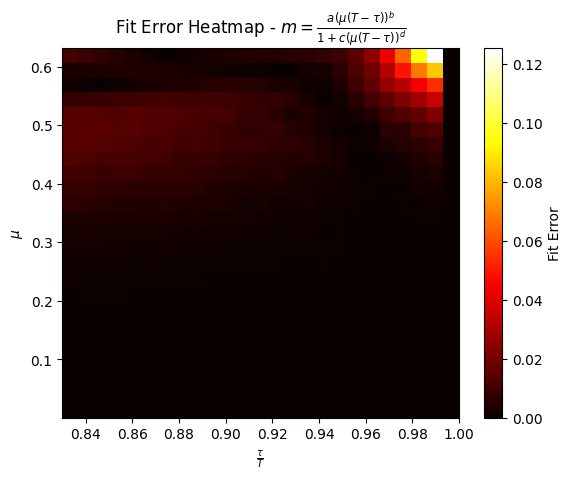

In [35]:
plt.imshow(np.absolute(y_pred.reshape(mean_val_grid.shape) - mean_val_grid), 
           aspect="auto",
            cmap="hot",
            origin="lower",
            extent=[tau_vals_short[0], tau_vals_short[-1], mu_vals_short[0], mu_vals_short[-1]],)
plt.colorbar(label=r"Fit Error")
plt.xlabel(r"$\frac{\tau}{T}$")
plt.ylabel(r"$\mu$")
plt.title(r"Fit Error Heatmap - $m=\frac{a(\mu(T-\tau))^b}{1+c(\mu(T-\tau))^d}$")
plt.show()

Using PySR (see simulate_fcpg.py), I deduced that a generalised bell-curve-esque form was a good expression for the variance, so I repeated the procedure of using curve_fit to find optimal parameters.

In [36]:
def bell_guess(x, p, q, r):
    mu, tau_rel = x
    tau = T*tau_rel
    com = mu*(T-tau)
    return com**p*np.exp(-q*com**r)

In [37]:
var_results_flat = var_val_grid.flatten().T

xdata = (mu_flat, tau_flat)
p0 = (4, 4, 4)

params_var, cov_var = curve_fit(bell_guess, xdata, var_results_flat, p0=p0)

In [38]:
y_pred_var = bell_guess(xdata, *params_var)

# Calculate R^2 score
ss_res = np.sum((var_results_flat - y_pred_var) ** 2)  # Residual sum of squares
ss_tot = np.sum((var_results_flat - np.mean(var_results_flat)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

print(f"R^2 = {r2:.4f}")

R^2 = 0.5571


Whilst the $R^2$ value was significantly lower for this expression, it retains the same areas of low error density, and so it is reasonable as long as we don't stray from these regions.

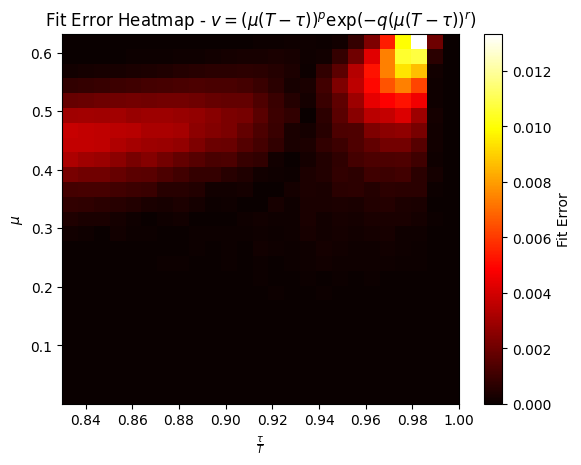

In [39]:
plt.imshow(np.absolute(y_pred_var.reshape(var_val_grid.shape) - var_val_grid), 
           aspect="auto",
            cmap="hot",
            origin="lower",
            extent=[tau_vals_short[0], tau_vals_short[-1], mu_vals_short[0], mu_vals_short[-1]],)
plt.colorbar(label=r"Fit Error")
plt.xlabel(r"$\frac{\tau} {T}$")
plt.ylabel(r"$\mu$")
plt.title(r"Fit Error Heatmap - $v=(\mu(T-\tau))^p\exp(-q(\mu(T-\tau))^r)$")
plt.show()

Below, I plot a gamma distribution and a log-normal distribution, using these expressions to calculate the parameters. The fit is not good enough, which encouraged me to pursue the Landau distribution.

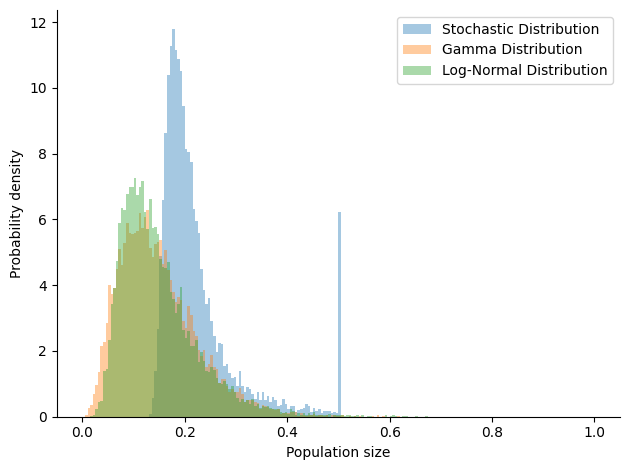

In [40]:
betaCancer = stochastic_growth(theta, tau, 0.06, gamma, nu, zeta, T, 10000, init)

x = np.linspace(0, 1, 1001)

mean = logistic((mu, tau/T), *params)
variance = bell_guess((mu, tau/T), *params_var)

alpha = mean**2 / variance
beta = mean / alpha
gamma_dist = stats.gamma(a=alpha, scale=beta)
x2 = gamma_dist.rvs(size=10000)

sigma_sq = np.log(1 + (variance / mean**2))
mu_prime = np.log(mean**2 / np.sqrt(variance + mean**2))
sigma = np.sqrt(sigma_sq)

lognorm_dist = stats.lognorm(s=sigma, scale=np.exp(mu_prime))
x3 = lognorm_dist.rvs(size=10000)

fig, ax = plt.subplots()

plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.hist(x2, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.hist(x3, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
# plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=["Stochastic Distribution", "Gamma Distribution", "Log-Normal Distribution"])
sns.despine()
plt.show()

Below, I repeat a similar process as for the mean and variance earlier, however now I am trying to directly find expressions for the parameters of the Landau distribution.

In [41]:
tau_rel = 0.83

mu_vals = np.linspace(0.005, 0.05, num=50)

c_vals = []
m_vals = []
pos_vals = []

for mu_val in tqdm(mu_vals):
  betaPeak = stochastic_growth(theta, tau_rel*T, mu_val, gamma, nu, zeta, T, 10000, init)

  pos = analytic_calculation(T - tau_rel*T, theta, mu_val, gamma, nu, zeta)

  loc, scale = stats.landau.fit(betaPeak)

  c = scale
  m = loc - (2 * c / np.pi * np.log(c))

  c_vals.append(c)
  m_vals.append(m)
  pos_vals.append(pos[2])

100%|██████████| 50/50 [02:44<00:00,  3.29s/it]


0.83


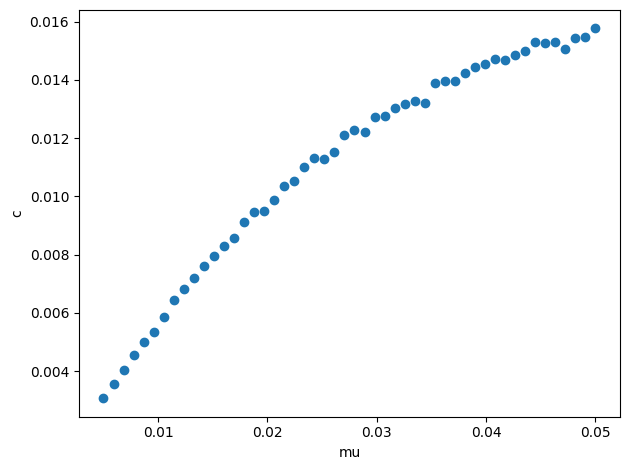

In [42]:
plt.scatter(mu_vals, c_vals)
plt.xlabel("mu")
plt.ylabel("c")
plt.tight_layout()
print(tau_rel)

In [43]:
mu_range = np.logspace(-5, -0.5, num=20)
tau_vals = np.linspace(0.83, 0.95, 20)
c_vals_double = np.zeros((len(mu_range), len(tau_vals)))
m_vals_double = np.zeros((len(mu_range), len(tau_vals)))
pos_vals_double = np.zeros((len(mu_range), len(tau_vals)))

In [ ]:
# Run the below to generate values - I have them pickled

for i in tqdm(range(len(mu_range))):
    for j in range(len(tau_vals)):
        betaPeak = stochastic_growth(theta, tau_vals[j]*T, mu_range[i], gamma, nu, zeta, T, 10000, init)

        pos = analytic_calculation(T - tau_vals[j]*T, theta, mu_range[i], gamma, nu, zeta)

        loc, scale = stats.landau.fit(betaPeak)

        c = scale
        m = loc - (2 * c / np.pi * np.log(c))

        c_vals_double[i, j] = c
        m_vals_double[i, j] = m
        pos_vals_double[i, j] = pos[2]

100%|██████████| 20/20 [17:11<00:00, 51.59s/it]


In [ ]:
f = open('pickles/c_val_grid.pkl', 'rb')
c_vals_double = pickle.load(f)
f.close()

f = open('pickles/m_val_grid.pkl', 'rb')
m_vals_double = pickle.load(f)
f.close()

f = open('pickles/pos_val_grid.pkl', 'rb')
pos_vals_double = pickle.load(f)
f.close()

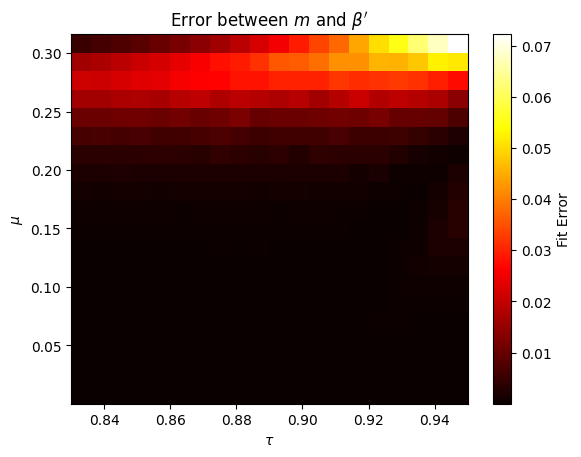

In [46]:
plt.imshow(
    np.absolute(m_vals_double - pos_vals_double),
    aspect="auto",
    cmap="hot",
    origin="lower",
    extent=[tau_vals[0], tau_vals[-1], mu_range[0], mu_range[-1]],
)
plt.colorbar(label="Fit Error")
plt.xlabel("$\\tau$")
plt.ylabel("$\\mu$")
plt.title("Error between $m$ and $\\beta^\\prime$")
plt.show()

In [47]:
def log_power(x, a, b, c, d, e):
  mu, tau_rel = x
  tau = T*tau_rel
  return (a*mu**d/(1+c*mu**e))*(T-tau)**b

In [48]:
tautau, mumu = np.meshgrid(tau_vals, mu_range)
mu_flat = mumu.flatten().T
tau_flat = tautau.flatten().T
results_flat = c_vals_double.flatten().T

xdata = (mu_flat, tau_flat)
p0 = (2, 0.9, 2, 0.5, 0.5)

params, cov = curve_fit(log_power, xdata, results_flat, p0=p0)

a, b, c, d, e = params
print(f"a={a}, b={b}, c={c}, d={d}, e={e}")

a=1.8873346747721416, b=-1.116676845442552, c=37.43777757328225, d=0.9122759427870403, e=1.8977976986355487


In [49]:
y_pred = log_power(xdata, *params)

# Calculate R^2 score
ss_res = np.sum((results_flat - y_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((results_flat - np.mean(results_flat)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

print(f"R^2 = {r2:.4f}")

R^2 = 0.9174


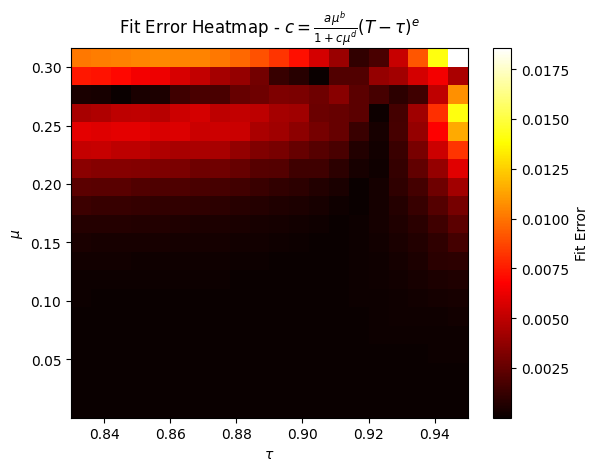

In [50]:
plt.imshow(
    np.absolute(y_pred.reshape(c_vals_double.shape) - c_vals_double),
    aspect="auto",
    cmap="hot",
    origin="lower",
    extent=[tau_vals[0], tau_vals[-1], mu_range[0], mu_range[-1]],
)
plt.colorbar(label="Fit Error")
plt.xlabel("$\\tau$")
plt.ylabel("$\\mu$")
plt.title("Fit Error Heatmap - $c=\\frac{a\\mu^b}{1+c\\mu^d}(T-\\tau)^e$")
plt.show()

Here, I demonstrate the fit of the Fréchet distribution to each peak of the methylation distribution.

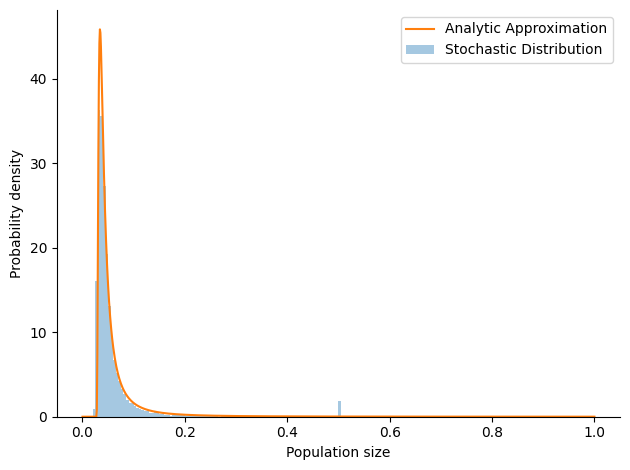

In [51]:
mu = 0.012

betaCancer = stochastic_growth(theta, tau, mu, gamma, nu, zeta, T, 10000, init)

x = np.linspace(0, 1, 1001)
pdf = np.exp(demeth_homo_init_lpdf(x, theta, mu, tau, T))

fig, ax = plt.subplots()

plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=["Analytic Approximation", "Stochastic Distribution"])
sns.despine()
plt.show()

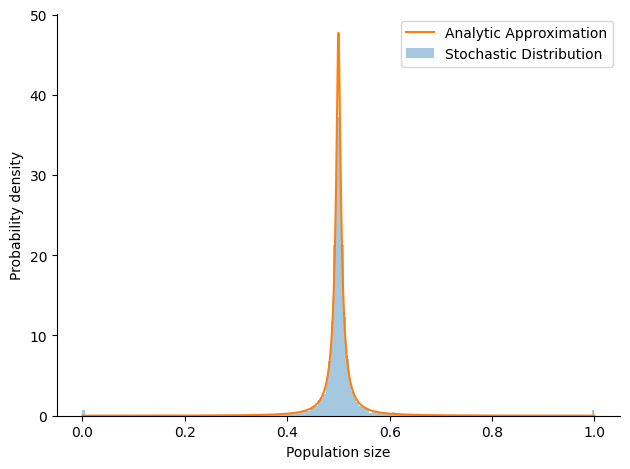

In [52]:
betaCancer = stochastic_growth(theta, tau, 1e-12, 1e-12, 0.012, 0.012, T, 10000, 1)

x = np.linspace(0, 1, 1001)
pdf = np.exp(meth_hetero_init_lpdf(x, theta, 0.012, 0.012, tau, T))

fig, ax = plt.subplots()


plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=["Analytic Approximation", "Stochastic Distribution"])
sns.despine()
plt.show()

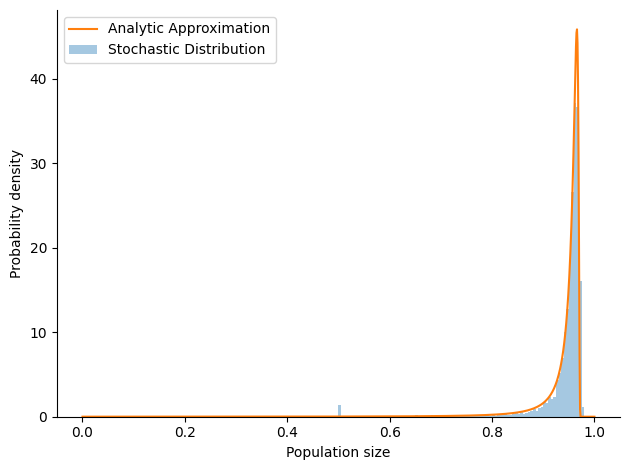

In [53]:
mu = 0.012

betaCancer = stochastic_growth(theta, tau, 1e-12, 0.012, 1e-12, 1e-12, T, 10000, 2)

x = np.linspace(0, 1, 1001)
pdf = np.exp(meth_homo_init_lpdf(x, theta, 0.012, tau, T))

fig, ax = plt.subplots()

plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=["Analytic Approximation", "Stochastic Distribution"])
sns.despine()
plt.show()

Here is the distinctive "W-shaped" distribution for three separate sets of parameter values. Note that proprtional increases in $\mu$ and $\gamma$ cause the outermost (homozygous) peaks to shrink and more probability mass to join the central peak, while an increase in $\gamma$ and $\zeta$ but not $\mu$ causes the distributon to skew leftwards, with more fCpGs successfully travelling from the homozygous methylated peak across to the homozygous demethylated peak.

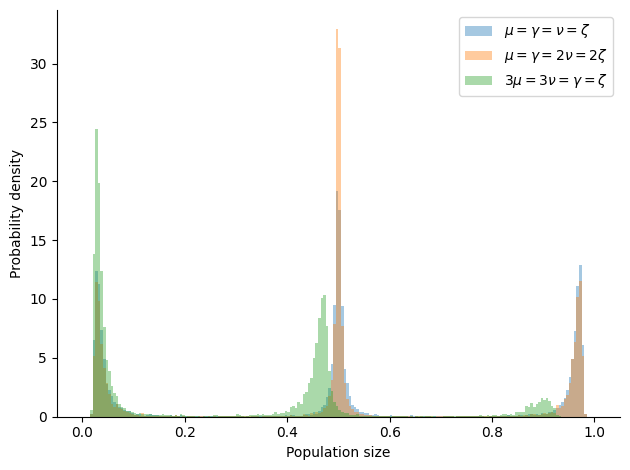

In [54]:
init = None

betaCancer_even = stochastic_growth(theta, tau, 0.01, 0.01, 0.01, 0.01, T, 10000, init)
betaCancer_smallnuzeta = stochastic_growth(theta, tau, 0.01, 0.01, 0.005, 0.005, T, 10000, init)
betaCancer_largegammazeta = stochastic_growth(theta, tau, 0.01, 0.03, 0.01, 0.03, T, 10000, init)

fig, ax = plt.subplots()

plt.hist(betaCancer_even, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.hist(betaCancer_smallnuzeta, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.hist(betaCancer_largegammazeta, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=[r"$\mu=\gamma=\nu=\zeta$", r"$\mu=\gamma=2\nu=2\zeta$", r"$3\mu=3\nu=\gamma=\zeta$"])
sns.despine()
plt.show()

Below is the PDF of the combined Fréchet distributions atop a histogram of simulated data.

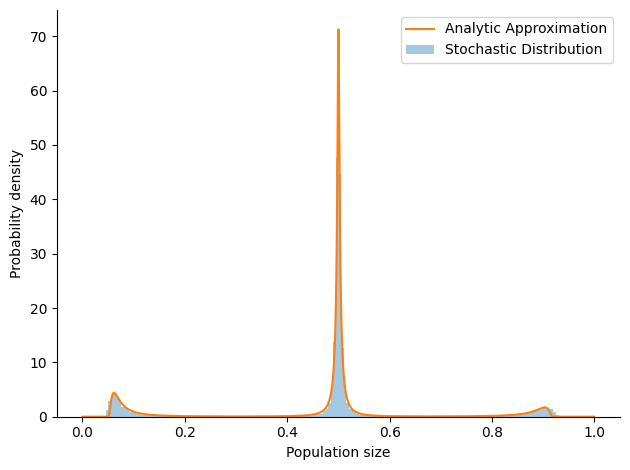

In [ ]:
mu = 0.005
gamma = 0.005
nu = 0.025
zeta = 0.025
theta = 2.4
tau = 45

betaCancer = stochastic_growth(theta, tau, mu, gamma, nu, zeta, T, 10000, init)

x = np.linspace(0, 1, 1001)
pdf = np.exp(combined_lpdf(x, theta, tau, mu, gamma, nu, zeta, T))

fig, ax = plt.subplots()

plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=["Analytic Approximation", "Stochastic Distribution"])
sns.despine()
plt.show()